In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import time
import re

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from openai import AzureOpenAI
from groq import Groq

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\lenovo\Desktop\LLM_Evaluation\data\processed\combined_medical_mcq_600.csv")
df.head()

,input,Correct Answer,Correct Option,source
0,A 50-year-old female presents to the office wi...,fibromyalgia,B,Professional Medicine
1,Once a prescribed unit of blood product has be...,30 minutes.,A,Clinical Knowledge
2,Removal of adhesive strips:\n\nA. can be carri...,can be carried out by the patient.,A,Clinical Knowledge
3,"A 14-year-old girl has had nausea, intermitten...",Microscopic examination of the stool,D,Professional Medicine
4,A 26-year-old male police officer comes to the...,Initiation of a daily corticosteroid inhaler,D,Professional Medicine


In [3]:
from dotenv import load_dotenv
load_dotenv()

# Azure OpenAI configuration
azure_api_key=os.getenv("AZURE_OPENAI_KEY")
azure_api_version= os.getenv("AZURE_OPENAI_VERSION")
azure_endpoint=os.getenv("AZURE_ENDPOINT")
AZURE_DEPLOYMENT_NAME = "gpt-4o-mini"

# Groq API configuration
groq_api_key = os.getenv("GROQ_API_KEY_SUB")

In [4]:
# Initialize the Azure OpenAI client
azure_client = AzureOpenAI(
    api_key=azure_api_key,
    api_version=azure_api_version,
    base_url=f"{azure_endpoint}/openai/deployments/{AZURE_DEPLOYMENT_NAME}"
)

# Initialize the Groq client
groq_client = Groq(api_key=groq_api_key)

In [5]:
# Define available Groq models
GROQ_MODELS = [
    "llama-3.3-70b-versatile",  # Llama 3 8B
    "mistral-saba-24b", # Llama 3 70B
   "llama-3.1-8b-instant",     # Gemma 7B Instruction Tuned
    "gemma2-9b-it", # Mixtral 8x7B
]

# Define all models for evaluation
MODELS = [
    {"provider": "azure", "name": AZURE_DEPLOYMENT_NAME},
    {"provider": "groq", "name": "llama-3.3-70b-versatile",},
    {"provider": "groq", "name": "mistral-saba-24b"},
    {"provider": "groq", "name": "llama-3.1-8b-instant"},
    {"provider": "groq", "name": "gemma2-9b-it"}
]

In [6]:
# Create directories for saving results
import os

results_dir = r"C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MMLU"
plots_dir = os.path.join(results_dir, "plots")

# Create directories if they don't exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

In [7]:
# Sample 100 questions from the dataset
sample_size = 100
sampled_df = df.sample(n=sample_size, random_state=42)
sampled_df = sampled_df.reset_index(drop=True)
print(f"Sampled {sample_size} questions for evaluation")

Sampled 100 questions for evaluation


In [8]:
# Define a function to convert answer options to a standardized format
def standardize_answer(answer):
    # First extract just the first letter or character if possible
    if answer and len(answer) > 0:
        # Extract the first character of the response
        first_char = answer[0].upper()
        # Check if it's a valid option
        if first_char in ['A', 'B', 'C', 'D']:
            return first_char
    
    # If we couldn't extract a simple A/B/C/D, try more pattern matching
    if answer:
        # Clean the answer string
        clean_answer = answer.upper().strip()
        
        # Try to match options with punctuation (A., B., etc.)
        if clean_answer.startswith('A.') or clean_answer == 'A':
            return 'A'
        if clean_answer.startswith('B.') or clean_answer == 'B':
            return 'B'
        if clean_answer.startswith('C.') or clean_answer == 'C':
            return 'C'
        if clean_answer.startswith('D.') or clean_answer == 'D':
            return 'D'
        
        # Try to find the option letter within the answer text
        for option in ['A', 'B', 'C', 'D']:
            if f"OPTION {option}" in clean_answer or f"({option})" in clean_answer:
                return option
    
    # Return the original answer if no match is found
    return answer

In [9]:
# Create prompt template for MCQ questions
def create_prompt(question):
    prompt = f"""
You are a medical expert taking a multiple-choice exam. Choose the single most appropriate answer from the given options.

Question: {question}

Please respond with ONLY the letter (A, B, C, or D) corresponding to your answer. Do not add any punctuation, explanation, or additional text - just the single letter.
"""
    return prompt.strip()

In [10]:
# Function to query Azure OpenAI models
def query_azure_model(prompt, model_name):
    try:
        response = azure_client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful medical assistant that answers multiple choice questions."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=10
        )
        answer = response.choices[0].message.content.strip()
        return standardize_answer(answer)
    except Exception as e:
        print(f"Error querying Azure model {model_name}: {str(e)}")
        return None

In [11]:
# Function to query Groq models
def query_groq_model(prompt, model_name):
    try:
        response = groq_client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful medical assistant that answers multiple choice questions."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=10
        )
        answer = response.choices[0].message.content.strip()
        return standardize_answer(answer)
    except Exception as e:
        print(f"Error querying Groq model {model_name}: {str(e)}")
        return None

In [12]:
# Create evaluation function
def evaluate_model(model_info, sampled_questions, results=None):
    if results is None:
        results = []
    
    provider = model_info['provider']
    model_name = model_info['name']
    print(f"Evaluating {provider} model: {model_name}")
    
    for index, row in tqdm(sampled_questions.iterrows(), total=len(sampled_questions)):
        question = row['input']
        correct_option = row['Correct Option']
        correct_answer = row['Correct Answer']
        
        prompt = create_prompt(question)
        
        # Query the appropriate model based on provider
        if provider == 'azure':
            model_answer = query_azure_model(prompt, model_name)
        elif provider == 'groq':
            model_answer = query_groq_model(prompt, model_name)
        else:
            model_answer = None
            print(f"Unknown provider: {provider}")
        
        # Check if the answer is correct
        is_correct = model_answer == correct_option if model_answer else False
        
        result = {
            'question_id': index,
            'model_provider': provider,
            'model_name': model_name,
            'model_answer': model_answer,
            'correct_option': correct_option,
            'correct_answer': correct_answer,
            'is_correct': is_correct
        }
        
        results.append(result)
        
        # Sleep to avoid rate limiting
        time.sleep(0.5)
    
    return results

In [13]:
# Run evaluation on a small subset first for testing
test_sample = sampled_df.head(3)
test_results = []

for model in MODELS[:2]:  # Test with just two models
    test_results = evaluate_model(model, test_sample, test_results)

# Convert to DataFrame for easier analysis
test_df = pd.DataFrame(test_results)
test_df

Evaluating azure model: gpt-4o-mini


  0%|          | 0/3 [00:00<?, ?it/s]

Evaluating groq model: llama-3.3-70b-versatile


  0%|          | 0/3 [00:00<?, ?it/s]

,question_id,model_provider,model_name,model_answer,correct_option,correct_answer,is_correct
0,0,azure,gpt-4o-mini,A,A,Ductography,True
1,1,azure,gpt-4o-mini,D,D,A moon face and a buffalo hump are characteris...,True
2,2,azure,gpt-4o-mini,B,B,The floor,True
3,0,groq,llama-3.3-70b-versatile,A,A,Ductography,True
4,1,groq,llama-3.3-70b-versatile,D,D,A moon face and a buffalo hump are characteris...,True
5,2,groq,llama-3.3-70b-versatile,B,B,The floor,True


In [14]:
# After confirming the small test works, run the full evaluation
all_results = []

for model in MODELS:
    all_results = evaluate_model(model, sampled_df, all_results)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(all_results)

# Save raw results
results_csv_path = os.path.join(results_dir, "mmlu_eval_results.csv")
results_df.to_csv(results_csv_path, index=False)

Evaluating azure model: gpt-4o-mini


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating groq model: llama-3.3-70b-versatile


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating groq model: mistral-saba-24b


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating groq model: llama-3.1-8b-instant


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluating groq model: gemma2-9b-it


  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
# Calculate accuracy metrics
def calculate_metrics(results_df):
    # Group by model and calculate accuracy
    metrics = results_df.groupby(['model_provider', 'model_name']).agg(
        accuracy=('is_correct', 'mean'),
        total_questions=('is_correct', 'count')
    ).reset_index()
    
    # Format accuracy as percentage
    metrics['accuracy_pct'] = metrics['accuracy'] * 100
    
    return metrics

metrics_df = calculate_metrics(results_df)
metrics_df

,model_provider,model_name,accuracy,total_questions,accuracy_pct
0,azure,gpt-4o-mini,0.87,100,87.0
1,groq,gemma2-9b-it,0.75,100,75.0
2,groq,llama-3.1-8b-instant,0.72,100,72.0
3,groq,llama-3.3-70b-versatile,0.83,100,83.0
4,groq,mistral-saba-24b,0.78,100,78.0


In [16]:
# Save metrics results
metrics_csv_path = os.path.join(results_dir, "mmlu_eval_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)

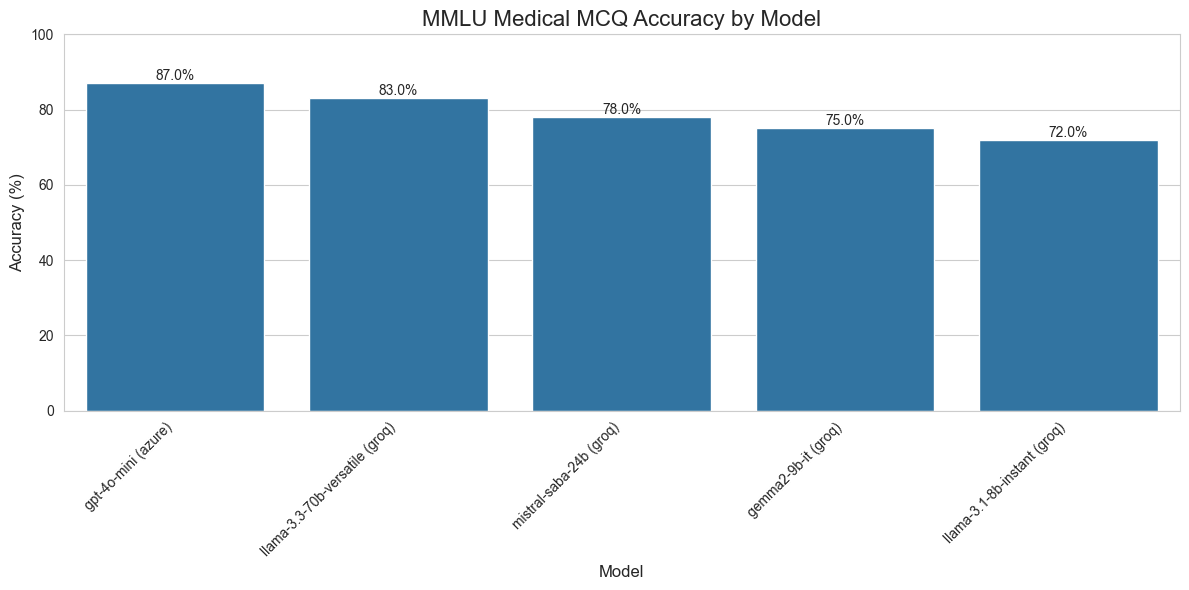

In [17]:
# Generate bar chart for accuracy comparison
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create model display names
metrics_df['display_name'] = metrics_df.apply(
    lambda x: f"{x['model_name']} ({x['model_provider']})", axis=1
)

# Sort by accuracy
metrics_df = metrics_df.sort_values('accuracy', ascending=False)

# Plot
ax = sns.barplot(x='display_name', y='accuracy_pct', data=metrics_df)
ax.set_title('MMLU Medical MCQ Accuracy by Model', fontsize=16)
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_ylim(0, 100)

# Add the accuracy percentage on top of each bar
for i, p in enumerate(ax.patches):
    ax.annotate(f"{p.get_height():.1f}%", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
accuracy_plot_path = os.path.join(plots_dir, "model_accuracy_comparison.png")
plt.savefig(accuracy_plot_path, dpi=300)
plt.show()

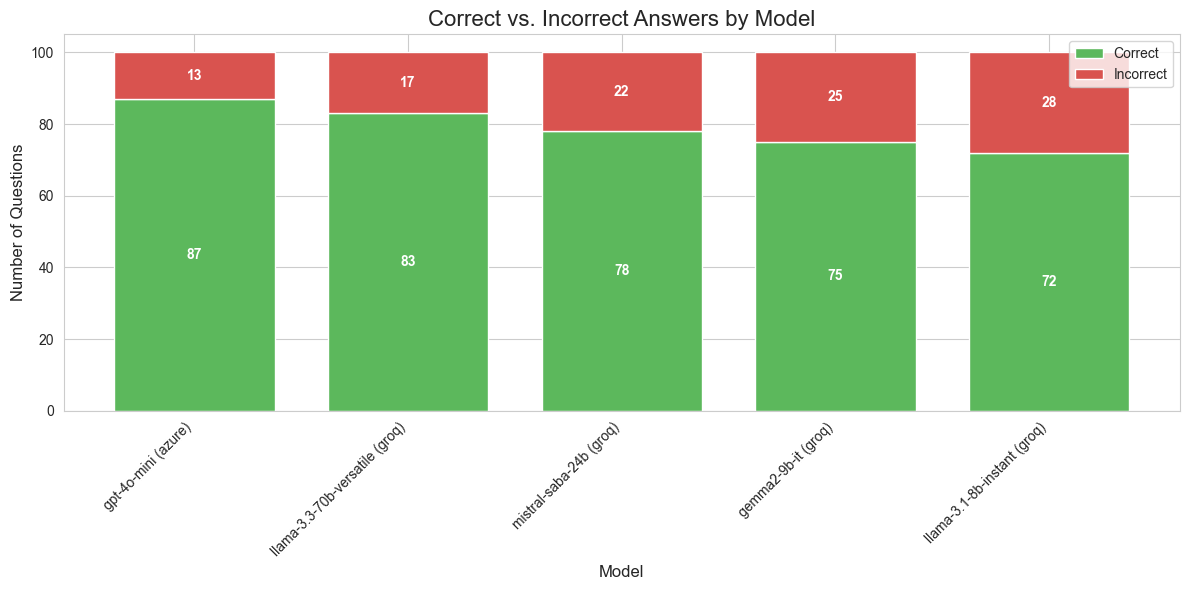

In [18]:
# Generate stacked bar chart showing correct vs incorrect answers
model_counts = results_df.groupby(['model_provider', 'model_name']).agg(
    correct=('is_correct', lambda x: sum(x)),
    incorrect=('is_correct', lambda x: sum(~x))
).reset_index()

# Create display names
model_counts['display_name'] = model_counts.apply(
    lambda x: f"{x['model_name']} ({x['model_provider']})", axis=1
)

# Sort by correct answers
model_counts = model_counts.sort_values('correct', ascending=False)

plt.figure(figsize=(12, 6))
ax = plt.subplot(111)

# Plot stacked bars
width = 0.75
bars1 = ax.bar(model_counts['display_name'], model_counts['correct'], width, color='#5cb85c', label='Correct')
bars2 = ax.bar(model_counts['display_name'], model_counts['incorrect'], width, bottom=model_counts['correct'], 
               color='#d9534f', label='Incorrect')

# Add counts to bars
for i, (c, ic) in enumerate(zip(model_counts['correct'], model_counts['incorrect'])):
    ax.text(i, c/2, str(c), ha='center', va='center', color='white', fontweight='bold')
    ax.text(i, c + ic/2, str(ic), ha='center', va='center', color='white', fontweight='bold')

ax.set_title('Correct vs. Incorrect Answers by Model', fontsize=16)
ax.set_ylabel('Number of Questions', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.legend(loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot
stacked_plot_path = os.path.join(plots_dir, "correct_incorrect_comparison.png")
plt.savefig(stacked_plot_path, dpi=300)
plt.show()

In [19]:
# Create a confusion matrix-style visualization per model
for model_idx, (provider, model_name) in enumerate(zip(
    metrics_df['model_provider'], metrics_df['model_name'])):
    
    model_results = results_df[(results_df['model_provider'] == provider) & 
                              (results_df['model_name'] == model_name)]
    
    # Count occurrences of predicted vs actual answers
    confusion = pd.crosstab(model_results['model_answer'], 
                            model_results['correct_option'],
                            rownames=['Predicted'],
                            colnames=['Actual'])
    
    # Make sure all options (A, B, C, D) are present
    for option in ['A', 'B', 'C', 'D']:
        if option not in confusion.index:
            confusion.loc[option] = 0
        if option not in confusion.columns:
            confusion[option] = 0
    
    # Sort the index and columns
    confusion = confusion.reindex(sorted(confusion.index), axis=0)
    confusion = confusion.reindex(sorted(confusion.columns), axis=1)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Answer Distribution: {model_name} ({provider})', fontsize=14)
    plt.tight_layout()
    path=r"C:\Users\lenovo\Desktop\LLM_Evaluation\results\QA\MMLU\plots"
    # Save the confusion matrix
    confusion_path = os.path.join(path, f"{model_name}_confusion.png")
    # confusion_path = confusion_path.replace('/', '_').replace('\\', '_')
    plt.savefig(confusion_path, dpi=300)
    plt.close()

In [20]:
# Generate a comparison summary report
def generate_summary_report(metrics_df, results_df):
    summary = """# MMLU Medical MCQ Evaluation Summary

## Overview
This report presents the results of evaluating various language models on medical multiple choice questions from the MMLU dataset.

## Dataset
- **Number of questions evaluated**: {}
- **Topic**: Medical knowledge (MCQs)

## Model Performance Summary
""".format(len(sampled_df))
    
    # Add the accuracy table
    summary += "\n### Accuracy Metrics\n\n"
    summary += metrics_df.sort_values('accuracy', ascending=False).to_markdown(index=False)
    
    # Add insights about top and bottom performers
    top_model = metrics_df.loc[metrics_df['accuracy'].idxmax()]
    bottom_model = metrics_df.loc[metrics_df['accuracy'].idxmin()]
    
    summary += f"\n\n## Key Findings\n\n"
    summary += f"* The best performing model was **{top_model['model_name']}** ({top_model['model_provider']}) with an accuracy of {top_model['accuracy_pct']:.2f}%\n"
    summary += f"* The lowest performing model was **{bottom_model['model_name']}** ({bottom_model['model_provider']}) with an accuracy of {bottom_model['accuracy_pct']:.2f}%\n"
    
    # Calculate performance gap between top and bottom models
    gap = top_model['accuracy_pct'] - bottom_model['accuracy_pct']
    summary += f"* The performance gap between the top and bottom model is {gap:.2f} percentage points\n"
    
    # Add average accuracy
    avg_accuracy = metrics_df['accuracy'].mean() * 100
    summary += f"* The average accuracy across all models was {avg_accuracy:.2f}%\n"
    
    # Add more insights if needed
    
    summary += "\n## Conclusion\n"
    if gap > 25:
        summary += "There is a significant performance gap between the best and worst models, indicating that model selection is critical for medical question answering tasks."
    elif gap > 10:
        summary += "There is a moderate performance gap between the models, suggesting that larger models generally perform better on medical knowledge tasks."
    else:
        summary += "All models performed relatively similarly on this task, suggesting that the medical knowledge is well-distributed across the different model architectures."
    
    return summary

summary_report = generate_summary_report(metrics_df, results_df)
print(summary_report)

# Save the summary report
summary_path = os.path.join(results_dir, "mmlu_eval_summary.md")
with open(summary_path, "w") as f:
    f.write(summary_report)

# MMLU Medical MCQ Evaluation Summary

## Overview
This report presents the results of evaluating various language models on medical multiple choice questions from the MMLU dataset.

## Dataset
- **Number of questions evaluated**: 100
- **Topic**: Medical knowledge (MCQs)

## Model Performance Summary

### Accuracy Metrics

| model_provider   | model_name              |   accuracy |   total_questions |   accuracy_pct | display_name                   |
|:-----------------|:------------------------|-----------:|------------------:|---------------:|:-------------------------------|
| azure            | gpt-4o-mini             |       0.87 |               100 |             87 | gpt-4o-mini (azure)            |
| groq             | llama-3.3-70b-versatile |       0.83 |               100 |             83 | llama-3.3-70b-versatile (groq) |
| groq             | mistral-saba-24b        |       0.78 |               100 |             78 | mistral-saba-24b (groq)        |
| groq             | gem